# 3D volume rendering of geophysical data using the yt platform

A notebook submission to the 2020 EarthCube Annual Meeting

**Authors**: Christopher Havlin<sup>1</sup>,  Benjamin Holtzman<sup>1</sup>, Kacper Kowalik<sup>2</sup>, Madicken Munk<sup>2</sup>, Sam Walkow<sup>2</sup>, Matthew Turk<sup>2</sup> 

1. Lamont-Doherty Earth Observatory, Columbia University 
2. University of Illinois Urbana-Champagne 

###  background

re-hash the abstract 

### notebook description

overview of what this notebook does exactly


In [8]:
# imports and initialization 
from yt_seismic import seis_model as SM,shapeplotter as SP, transferfunctions as TFs
import os, yt, numpy as np
import matplotlib.pyplot as plt
os.environ['YTVELMODELDIR']='./data' # local repo path to data directory (do not change)


### Loading netcdf files with yt

In [2]:
# choose model and plot settings
fname='NWUS11-S_percent.nc' # model selection

# load the model
interp_dict={'field':'dvs','max_dist':50000,'res':[10000,10000,10000],
              'input_units':'m','interpChunk':int(1e7)}
model=SM.netcdf(fname,interp_dict)
shortname=fname.split('.')[0]
datafld='dvs'
data={datafld:model.interp['data'][datafld]} # dict container for yt scene

# load the data as a uniform grid, create the 3d scene
sc_mult=1.0 # scale multiplier
bbox = model.cart['bbox'] # list-like [[xmin,xmax],[ymin,ymax],[zmin,zmax]]
ds = yt.load_uniform_grid(data,data[datafld].shape,sc_mult,bbox=bbox,nprocs=1,
                        periodicity=(True,True,True),unit_system="mks")

yt : [INFO     ] 2020-05-06 11:54:37,605 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-05-06 11:54:37,605 Parameters: domain_dimensions         = [287 271 237]
yt : [INFO     ] 2020-05-06 11:54:37,606 Parameters: domain_left_edge          = [-5201282.   -3445670.25  2740212.5 ]
yt : [INFO     ] 2020-05-06 11:54:37,606 Parameters: domain_right_edge         = [-2328344.5     -735306.5625  5113796.5   ]
yt : [INFO     ] 2020-05-06 11:54:37,606 Parameters: cosmological_simulation   = 0.0


In [3]:
sc = yt.create_scene(ds,datafld)

# Draw the domain boundary and useful grids
lat_rnge=[np.min(model.data.variables['latitude']),np.max(model.data.variables['latitude'])]
lon_rnge=[np.min(model.data.variables['longitude']),np.max(model.data.variables['longitude'])]
min_dep=0.
max_dep=1200.
R=6371.
r_rnge=[(R-max_dep)*1000.,(R-min_dep)*1000.]
Chunk=SP.sphericalChunk(lat_rnge,lon_rnge,r_rnge)
sc=Chunk.domainExtent(sc,RGBa=[1.,1.,1.,0.002],n_latlon=100,n_rad=50)
sc=Chunk.latlonGrid(sc,RGBa=[1.,1.,1.,0.005])
sc=Chunk.latlonGrid(sc,RGBa=[1.,1.,1.,0.002],radius=(R-410.)*1000.)
sc=Chunk.latlonGrid(sc,RGBa=[1.,1.,1.,0.002],radius=(R-max_dep)*1000.)
sc=Chunk.wholeSphereReference(sc,RGBa=[1.,1.,1.,0.002])

# Add shapefile data
shp_bbox=[lon_rnge[0],lat_rnge[0],lon_rnge[1],lat_rnge[1]]

for shpfi in ['us_states']:
    thisshp=SP.shapedata(shpfi,bbox=shp_bbox,radius=R*1000.)
    sc=thisshp.addToScene(sc)

clrs={
    'transform':[0.8,0.,0.8,0.05],
    'ridge':[0.,0.,0.8,0.05],
    'trench':[0.8,0.,0.,0.05],
    'global_volcanos':[0.,0.8,0.,0.05]
}
for bound in ['transform','ridge','trench','global_volcanos']:
    tect=SP.shapedata(bound,radius=R*1000.,buildTraces=False)
    sc=tect.buildTraces(RGBa=clrs[bound],sc=sc,bbox=shp_bbox)

In [4]:
# some camera settings
pos=sc.camera.position
Rmax=6371*1000.
center_vec=np.array([np.mean(bbox[0])/Rmax,np.mean(bbox[1])/Rmax,np.mean(bbox[2])/Rmax])
sc.camera.set_position(pos,north_vector=center_vec)
source = sc.sources['source_00']
source.tfh.set_log(False)

res=sc.camera.get_resolution()
res_factor=1
new_res=(int(res[0]*res_factor),int(res[1]*res_factor))
sc.camera.set_resolution(new_res)

zoom_factor=0.7 # < 1 zooms in
init_width=sc.camera.width
sc.camera.width = (init_width * zoom_factor)
sc.camera.rotate(0*np.pi/180)

In [5]:
# function for plotting transfer functions
def plotTf(tfOb):
    f=plt.figure()
    ax=plt.axes()
    ax=tfOb.addHist(ax=ax,density=True,color=(0.,0.,0.,1.))
    ax=tfOb.addTFtoPlot(ax=ax)
    ax.set_xlabel('dvs')        
    plt.show()

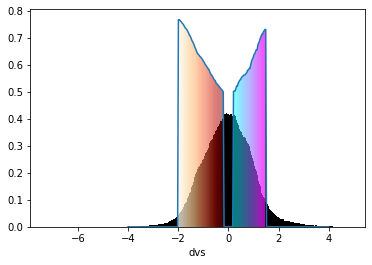

In [6]:
# setting up transfer functions 
tfOb = TFs.dv(data[datafld].ravel(),bounds=[-4,4])

def alphaHist(histData,maxAlpha,alphaFac):
    if alphaFac>maxAlpha:
        alphaFac=maxAlpha
    return maxAlpha - alphaFac*histData/histData.max()

bnds=[-2,-.2]
TFseg=TFs.TFsegment(tfOb,bounds=bnds,cmap='OrRd')
histData,_=tfOb.calcHist(bin_edges=TFseg.dvbins)
tfOb.addTFsegment(alphaHist(histData,.8,0.3),TFseg)

bnds=[.2,1.5]
TFseg=TFs.TFsegment(tfOb,bounds=bnds,cmap='cool')
histData,_=tfOb.calcHist(bin_edges=TFseg.dvbins)
tfOb.addTFsegment(alphaHist(histData,.8,0.3),TFseg)
plotTf(tfOb)



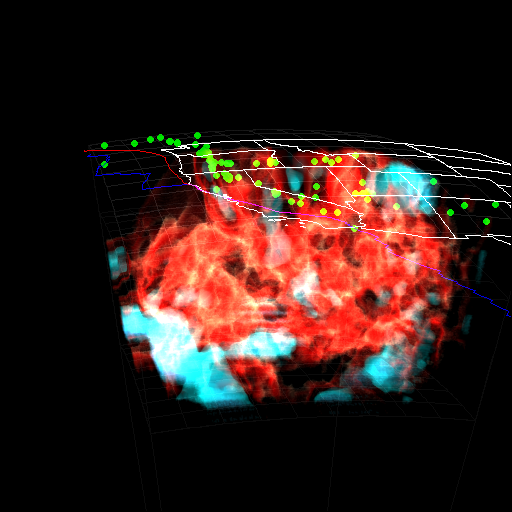

In [16]:
# render the image 
source.set_transfer_function(tfOb.tf)
sc.show(sigma_clip=1)